In [145]:
from functions import *
from scipy import stats
import statsmodels.api as sm

In [146]:
X = pd.read_csv("indep_x.csv", index_col = 0)
y = pd.read_csv("dep_y.csv", index_col = 0)

In [147]:
X_notreated = X.drop(["treated"], axis = 1)

In [148]:
X_notreated = X_notreated[X_notreated["gpa"]!=31]

In [149]:
data_nout = pd.read_csv("data_nout.csv", index_col = 0)

In [150]:
x_nout = data_nout[['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
                      'importance', 'expected_grade', 'knowledge']].copy()

y_nout = data_nout[['grade_goal','confidence', 'anxiety', 'time', 'exam_date']].copy()

treatment = data_nout["treated"].copy()

Total variance explained by the PCA 0.33257660380056886
Silhouette Score: 0.5579550585017119


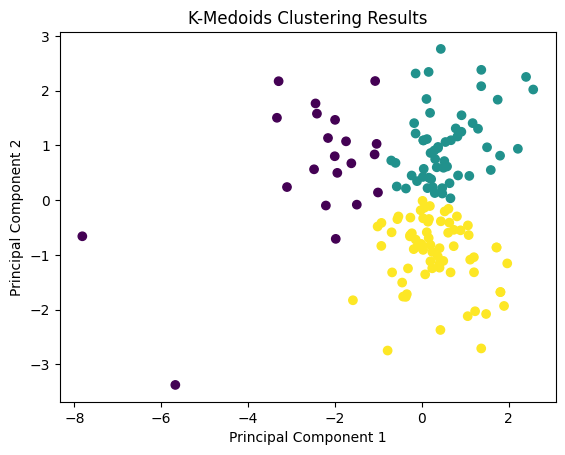

In [151]:
labels = clustering_medoids_quick(X_notreated, n_comp= 2, dist_metric= "manhattan", n_clusters= 3, plot="yes");

In [152]:
labels_df = pd.DataFrame(labels)
labels_df.columns = ["cluster"]
labels_df.index = X_notreated.index

In [153]:
(X_notreated.shape,labels_df.shape)

((145, 10), (145, 1))

In [154]:
X_cluster = pd.concat([X_notreated, labels_df], axis = 1)

In [158]:
X_cluster.shape

(145, 11)

In [159]:
treatment_status = X[X["gpa"]!=31]["treated"].copy()

In [160]:
X_cl_tstatus = pd.concat([X_cluster, treatment_status], axis = 1)

In [161]:
X_cl_tstatus.shape

(145, 12)

In [162]:
y_gpafixed = y[X["gpa"]!=31].copy()
y_gpafixed = pd.concat([y_gpafixed, labels_df], axis = 1)

In [163]:
ate_results = {}
p_values = {}

for cluster_id in X_cl_tstatus['cluster'].unique():
    ate_results[cluster_id] = {}
    p_values[cluster_id] = {}
    for var in y_gpafixed.columns[:-1]:
        cluster_data = X_cl_tstatus[X_cl_tstatus['cluster'] == cluster_id].drop(["cluster"], axis = 1)
        X = sm.add_constant(cluster_data) 
        y_reg = y_gpafixed[y_gpafixed['cluster'] == cluster_id].copy()
        y_reg = y_reg[var] 
        model = sm.RLM(y_reg, X, M = sm.robust.norms.HuberT()).fit()
        ate_results[cluster_id][var] = model.params['treated']
        p_values[cluster_id][var] = model.pvalues['treated']

In [164]:
ate_df = pd.DataFrame(ate_results)
p_values_df = pd.DataFrame(p_values)

In [165]:
pd.options.display.float_format = '{:.4f}'.format

In [171]:
X_cl_tstatus["cluster"].value_counts()

cluster
2    69
1    55
0    21
Name: count, dtype: int64

In [167]:
ate_df

,2,0,1
grade_goal,-2.2897,-2.2036,0.0349
confidence,-0.1817,-0.2831,0.1919
anxiety,0.2750,-0.2136,-0.0300
time,0.3962,0.5344,0.2992
exam_date,-0.0000,-0.4727,0.0000


**Cluster 2**: Younger, mostly female, first-year student with a high GPA, high expectations, but relatively low initial knowledge of the course. They are discouraged by the average grade information, leading to lower confidence and increased anxiety, even though they plan to study more.

**Cluster 0**: Older, mainly male, not necessarily a first-year student, with an below average GPA and lower expectations. Some of them have taken the course before, dislike it somewhat, and are discouraged by the average grade information, leading to decreased confidence, increased study time, and a desire to anticipate the exam relative to their initial idea.

**Cluster 1**: Younger, mostly male, first-year student with a high GPA and a positive attitude towards the course. They consider the course important, have some prior knowledge of exam statistics, and are not discouraged by the average grade information. They maintain their confidence and study effort.

In [168]:
X_cluster.groupby("cluster")[X_cluster.columns].mean()

,age,gender,scholarship,1st_year,gpa,1st_time,taste,importance,expected_grade,knowledge,cluster
cluster,,,,,,,,,,,
0,21.4762,0.1905,0.0000,0.5714,22.6190,0.9048,2.9048,3.4762,21.0952,0.1429,0.0000
1,19.7455,0.2000,0.0000,1.0000,24.5818,0.9818,3.7636,4.3455,21.4364,0.4364,1.0000
2,19.3043,0.7681,0.1594,1.0000,25.5797,1.0000,3.1159,3.7536,22.4783,0.2609,2.0000


In [169]:
y_gpafixed.groupby("cluster")[y_gpafixed.columns].mean()

,grade_goal,confidence,anxiety,time,exam_date,cluster
cluster,,,,,,
0,23.3333,3.3810,3.0000,4.6667,1.3810,0.0000
1,25.1636,3.5091,3.3273,4.6545,1.0909,1.0000
2,25.6522,3.4928,3.4058,4.5507,1.1014,2.0000


In [170]:
p_values_df

,2,0,1
grade_goal,0.0000,0.1580,0.9727
confidence,0.3060,0.3084,0.4212
anxiety,0.3816,0.5682,0.9082
time,0.1374,0.4575,0.3182
exam_date,0.8911,0.1948,0.0431


### Tests

In [174]:
cluster_1_gg = y_gpafixed[y_gpafixed["cluster"]==0]["grade_goal"].values
cluster_2_gg = y_gpafixed[y_gpafixed["cluster"]==2]["grade_goal"].values

In [175]:
t_stat, p_value = stats.ttest_ind(cluster_1_gg, cluster_2_gg)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.9450933604126455, P-value: 0.0041299233518829115


In [176]:
cluster_1_a = y_gpafixed[y_gpafixed["cluster"]==0]["anxiety"].values
cluster_2_a = y_gpafixed[y_gpafixed["cluster"]==2]["anxiety"].values

In [177]:
t_stat, p_value = stats.ttest_ind(cluster_1_a, cluster_2_a)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -1.6043858447432444, P-value: 0.11221215469945697


In [178]:
cluster_1_ed = y_gpafixed[y_gpafixed["cluster"]==0]["exam_date"].values
cluster_2_ed = y_gpafixed[y_gpafixed["cluster"]==2]["exam_date"].values

In [179]:
t_stat, p_value = stats.ttest_ind(cluster_1_ed, cluster_2_ed)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.533635403397399, P-value: 0.013059182164119198


### Regression Tests

In [209]:
X_dummies = pd.get_dummies(X_cl_tstatus, columns=['cluster'], drop_first=True, dtype = int)

In [210]:
X_reg = X_dummies[['cluster_1', 'cluster_2',
                    "treated"]].copy()

In [211]:
X_reg = sm.add_constant(X_reg)

In [225]:
y_gpafixed.columns

Index(['grade_goal', 'confidence', 'anxiety', 'time', 'exam_date', 'cluster'], dtype='object')

In [230]:
y_var = y_gpafixed["grade_goal"].copy()

In [231]:
model = sm.OLS(y_var, X_reg).fit(cov = "HC3")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             grade_goal   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3.591
Date:                Sat, 29 Mar 2025   Prob (F-statistic):             0.0153
Time:                        10:43:21   Log-Likelihood:                -373.87
No. Observations:                 145   AIC:                             755.7
Df Residuals:                     141   BIC:                             767.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.5413      0.718     32.798      0.000      22.122      24.960
cluster_1      2.1623      0.856      2.527      0.013       0.471       3.854
cluster_2      2.5666      0.821      3.126      0.002       0.944       4.190
treated       -0.8736      0.554     -1.576      0.117      -1.970       0.222
==============================================================================
Omnibus:                        1.339   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.431
Skew:                          -0.204   Prob(JB):                        0.489
Kurtosis:                       2.734   Cond. No.                         6.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
X_reg2 = X_dummies[['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
                    'importance', 'expected_grade', 'knowledge',
                    "treated"]].copy()

In [233]:
model2 = sm.OLS(y_var, sm.add_constant(X_reg2)).fit(cov = "HC3")
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.311   
Dependent Variable: grade_goal       AIC:                716.8011
Date:               2025-03-29 10:43 BIC:                752.5219
No. Observations:   145              Log-Likelihood:     -346.40 
Df Model:           11               F-statistic:        6.919   
Df Residuals:       133              Prob (F-statistic): 3.73e-09
R-squared:          0.364            Scale:              7.5871  
-----------------------------------------------------------------
                  Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------
const            -4.7334   5.8303 -0.8119 0.4183 -16.2654  6.7987
age               0.2217   0.2148  1.0319 0.3040  -0.2032  0.6466
gender            0.3988   0.4915  0.8113 0.4186  -0.5734  1.3710
scholarship       0.1035   0.9061  0.1142 0.9092  -1.6887  1.8958
1st_year          1.1857   1.0915  1.0863 0.2793  -0.9733  3.3447
gpa               0.4354   0.0972  4.4804 0.0000   0.2432  0.6277
1st_time         -0.8205   1.6703 -0.4912 0.6241  -4.1242  2.4832
taste             1.1483   0.4131  2.7801 0.0062   0.3313  1.9654
importance        0.4802   0.3910  1.2282 0.2215  -0.2931  1.2535
expected_grade    0.4177   0.0966  4.3235 0.0000   0.2266  0.6088
knowledge         0.2814   0.5171  0.5441 0.5873  -0.7415  1.3042
treated          -1.4621   0.4800 -3.0460 0.0028  -2.4116 -0.5127
-----------------------------------------------------------------
Omnibus:              4.085        Durbin-Watson:           1.936
Prob(Omnibus):        0.130        Jarque-Bera (JB):        4.682
Skew:                 0.137        Prob(JB):                0.096
Kurtosis:             3.836        Condition No.:           997  
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""